# Initialize Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as pe
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import tensorflow as tf
import ROOT
import uproot
import os
import sys
import tqdm
import pandas as pd
import pickle as pkl
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from scipy.spatial.distance import cdist

%jsroot on
# %matplotlib qt
%matplotlib inline

Welcome to JupyROOT 6.30/02


In [2]:
sys.path.append('../python/')
from filterMethods import *
from timeMethods import *
from gridMethods import *
from trackReconstructionMethods import *
from vertexReconstructionMethods import *
from hitAccuracyMethods import *
from statisticsMethods import *
from importMethods import *
from constants import *
import plotParameters

In [3]:
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

# Load Data

In [4]:
# fileName = '../runs/event_2mu100MeVBackToBack_usedForTrackReconstruction.root'
# fileName = '../runs/calibration_2.42^3_10000gamma_1000events.root'
# fileName = '../runs/calibration_2.42^3_10000gamma_1000events_0cmFOVL_+-1.21randPosNoSteps_randDir.root'
# fileName = '../runs/calibration_2.42^3_10000gamma_1000events_20cmFOVL.root'
# fileName = '../build/calibration.root'
# fileName = '../build/event100.root'
# fileNames = [
#     '../build/event_1.root',
#     '../build/event_2.root'
# ]
fileNames = ['../build/multievent_{}.root'.format(i) for i in range(200)] # 100

histDir = '/photoSensor_hits_histograms'
treeName = 'photoSensor_hits;1'
    
minInitialPositions = 10
fileNames = [fileName for fileName in fileNames if len(get_photosensor_hits_position_initial(fileName, treeName)) > minInitialPositions]
print('len(fileNames):', len(fileNames))

# for fileName in tqdm.tqdm(fileNames):
    # print(get_histogram_names    (fileName, histDir))
    # print(get_histogram_titles   (fileName, histDir))
    # print(get_histogram_positions(fileName, histDir))
    # print(get_histogram_walls    (fileName, histDir))
    # print()


len(fileNames): 141


In [5]:
treeName = 'photoSensor_hits;1'
dfs_hits = []
for fileName in tqdm.tqdm(fileNames):
    df_hits = pd.DataFrame(columns=['sensor_name', 'sensor_direction', 'sensor_position', 'relativePosition', 'relativePosition_binned', 'time'])
    df_hits['sensor_name'            ] = get_photosensor_hits_photosensor_ID          (fileName, treeName)
    df_hits['sensor_direction'       ] = get_photosensor_hits_photosensor_direction   (fileName, treeName)
    df_hits['sensor_position'        ] = get_photosensor_hits_photosensor_position    (fileName, treeName)
    df_hits['sensor_wall'            ] = get_photosensor_hits_photosensor_wall        (fileName, treeName)
    df_hits['relativePosition'       ] = get_photosensor_hits_position_relative       (fileName, treeName)
    df_hits['relativePosition_binned'] = get_photosensor_hits_position_relative_binned(fileName, treeName, histDir)
    df_hits['relativePosition_nBin'  ] = get_photosensor_hits_position_relative_nBin  (fileName, treeName, histDir)
    df_hits['initialPosition'        ] = get_photosensor_hits_position_initial        (fileName, treeName)
    dfs_hits.append(df_hits)
    # print('df_hits length:', len(df_hits))

  0%|          | 0/141 [00:00<?, ?it/s]

100%|██████████| 141/141 [00:27<00:00,  5.22it/s]


In [6]:
treeName = 'primary;1'
dfs_primary = []
for fileName in tqdm.tqdm(fileNames):
    df_primary = pd.DataFrame(columns=['position', 'pdg'])
    df_primary['position' ] = get_primary_position(fileName, treeName)
    df_primary['pdg'      ] = get_primary_pdg     (fileName, treeName)
    df_primary = df_primary[df_primary['pdg'] == 13] # muon
    df_primary = df_primary[df_primary['position'].apply(lambda x:
        x[0] > -DETECTOR_SIZE_MM[0]/2 and x[0] < DETECTOR_SIZE_MM[0]/2 and
        x[1] > -DETECTOR_SIZE_MM[1]/2 and x[1] < DETECTOR_SIZE_MM[1]/2 and
        x[2] > -DETECTOR_SIZE_MM[2]/2 and x[2] < DETECTOR_SIZE_MM[2]/2
    )]
    dfs_primary.append(df_primary)
    # print('df_primary length:', len(df_primary))

100%|██████████| 141/141 [00:01<00:00, 110.19it/s]


In [7]:
if len(dfs_primary) != len(dfs_hits):
    raise Exception('len(dfs_primary) != len(dfs_hits)')

# Filter Hits

In [8]:
search_radius = 0
search_number = 0

for i in tqdm.tqdm(range(len(dfs_hits))):
    dfs_hits[i] = filter_hits(dfs_hits[i], radius=search_radius, number=search_number)

100%|██████████| 141/141 [00:03<00:00, 40.66it/s]


# Basic Hit Reco

In [9]:
def rToTheta(r):
    return r/(CM_PER_RAD*MM_PER_CM)
for i in tqdm.tqdm(range(len(dfs_hits))):
    dfs_hits[i] = make_r(dfs_hits[i])
    dfs_hits[i] = filter_r(dfs_hits[i], Y_LIM)
    dfs_hits[i] = make_theta(dfs_hits[i], rToTheta)
    dfs_hits[i] = make_phi(dfs_hits[i])
    dfs_hits[i] = make_reconstructedVector_direction(dfs_hits[i])
    dfs_hits[i] = make_relativeVector(dfs_hits[i])

100%|██████████| 141/141 [00:04<00:00, 28.76it/s]


# Plotting Methods

In [10]:
color_oranges = cm.Blues_r  ([0.5,0.6,0.9])
color_blues   = cm.Oranges_r([0.5,0.6,0.9])
blue_1 = "#B6CEC7"
blue_2 = "#92C1A5"
blue_3 = "#889D8E"
red_1  = "#C16464"
red_2  = "#B64D4D"
red_3  = "#FBE6E5"
twilight = cm.twilight(np.linspace(0,1,40))

# Make or Load Grid

In [11]:
gridSize = (20, 20, 20)
makeErrors = False
save = False
savePlots = False
load = False
useWalls = False
plotRecoName = '{}x{}x{}_{}_{}'.format(gridSize[0], gridSize[1], gridSize[2], fileName.split('/')[-1].split('.')[0], {True:'withErrors', False:'noErrors'}[makeErrors])
print('plotRecoName:', plotRecoName)

plotRecoName: 20x20x20_multievent_198_noErrors


# Data

In [12]:
gridSize_input = gridSize
gridSize_output = np.array([20, 20, 20]) # 92, 92, 92

X_size = (len(dfs_hits),) + gridSize_input + (6,)
Y_size = (len(dfs_hits),) + (gridSize_output[0], gridSize_output[1], gridSize_output[2])

X = np.zeros((len(dfs_hits),) + gridSize_input + (6,))
Y = np.zeros((len(dfs_hits),) + (gridSize_output[0], gridSize_output[1], gridSize_output[2]))

for i, (df_hits, df_primary) in tqdm.tqdm(enumerate(zip(dfs_hits, dfs_primary))):
    X[i], grid_ind, grid_pos = make_voxelGrid(
        df_hits,
        shape=gridSize_input,
        detectorDimensions=DETECTOR_SIZE_MM,
        sensorPositions=np.array(df_hits['sensor_position'].to_list()).reshape(-1,3),
        recoDirections=np.array(df_hits['reconstructedVector_direction'].to_list()).reshape(-1,3),
        hitWeights=[1 for i in range(len(df_hits))],
        make_errors=makeErrors,
        useWalls=useWalls,
        sensorWalls=df_hits['sensor_wall'].to_numpy(),
        wallOperation=expNWalls,
        returnWalls=True)
    Y[i] = make_voxelGrid_truth(
        # np.array(df_hits['initialPosition'].to_list()),
        np.array(df_primary['position'].to_list()),
        shape=gridSize_output,
        detectorDimensions=DETECTOR_SIZE_MM,
        makeErrors=False)[0]*10

print('X.shape:', X.shape)
print('Y.shape:', Y.shape)
print()
print('grid_ind.shape:', grid_ind.shape)
print('grid_pos.shape:', grid_pos.shape)

141it [00:06, 22.96it/s]


X.shape: (141, 20, 20, 20, 6)
Y.shape: (141, 20, 20, 20)

grid_ind.shape: (8000, 3)
grid_pos.shape: (8000, 3)


In [13]:
nTest = 20
testIndices = np.random.choice(len(dfs_hits), nTest, replace=False)

X_train = np.delete(X, testIndices, axis=0)
Y_train = np.delete(Y, testIndices, axis=0)
X_test = X[testIndices]
Y_test = Y[testIndices]

X_train_indices = np.delete(np.arange(len(dfs_hits)), testIndices)
Y_train_indices = np.delete(np.arange(len(dfs_hits)), testIndices)
X_test_indices = np.array(testIndices)
Y_test_indices = np.array(testIndices)

print('X_train.shape:', X_train.shape)
print('Y_train.shape:', Y_train.shape)
print('X_test.shape:', X_test.shape)
print('Y_test.shape:', Y_test.shape)

X_train.shape: (121, 20, 20, 20, 6)
Y_train.shape: (121, 20, 20, 20)
X_test.shape: (20, 20, 20, 20, 6)
Y_test.shape: (20, 20, 20, 20)


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_94593/2075693218.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(grid_pos[nonZeroInd, 0], grid_pos[nonZeroInd, 1], grid_pos[nonZeroInd, 2], c='r', cmap=cm.viridis, s=100, alpha=1)
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_94593/2075693218.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(grid_pos[nonZeroInd, 0], grid_pos[nonZeroInd, 1], grid_pos[nonZeroInd, 2], c='b', cmap=cm.viridis, s=100, alpha=1)
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_94593/2075693218.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(initialPos[:, 0], initialPos[:, 1], initialPos[:, 2], c='g', cmap=cm.viridis, s=100, alpha=1)


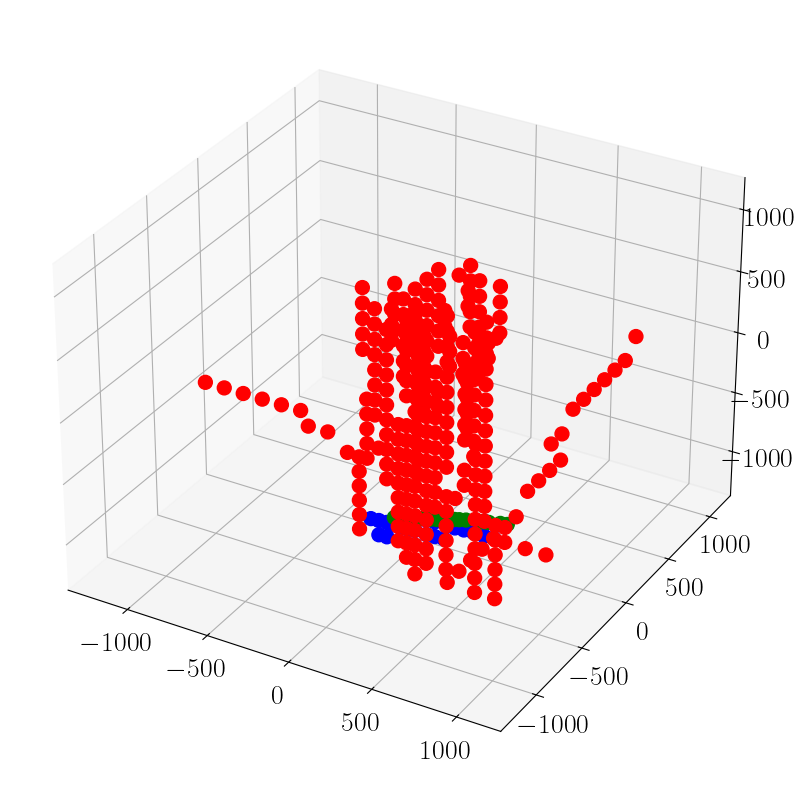

In [14]:
# %matplotlib qt
%matplotlib inline

from scipy.ndimage import zoom

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ind = 50

nonZeroInd = np.where(np.sum(X[ind], axis=-1).flatten() > 0)
ax.scatter(grid_pos[nonZeroInd, 0], grid_pos[nonZeroInd, 1], grid_pos[nonZeroInd, 2], c='r', cmap=cm.viridis, s=100, alpha=1)

nonZeroInd = np.where(Y[ind].flatten() > 0)
ax.scatter(grid_pos[nonZeroInd, 0], grid_pos[nonZeroInd, 1], grid_pos[nonZeroInd, 2], c='b', cmap=cm.viridis, s=100, alpha=1)

initialPos = np.array(dfs_hits[ind]['initialPosition'].to_list())
ax.scatter(initialPos[:, 0], initialPos[:, 1], initialPos[:, 2], c='g', cmap=cm.viridis, s=100, alpha=1)

plt.show()


# Model

In [15]:
input_data = tf.keras.layers.Input(shape=X_size[1:])
summed_data = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=-1))(input_data)

dropoutRate = 0.2

conv_1_1 = tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', padding='valid')(input_data)
conv_1_1_drop = tf.keras.layers.Dropout(dropoutRate)(conv_1_1)
maxPool_1_1 = tf.keras.layers.MaxPooling3D((2, 2, 2))(conv_1_1_drop)
conv_1_2 = tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', padding='valid')(maxPool_1_1)
conv_1_2_drop = tf.keras.layers.Dropout(dropoutRate)(conv_1_2)
maxPool_1_2 = tf.keras.layers.MaxPooling3D((2, 2, 2))(conv_1_2_drop)

mlp_conv = tf.keras.layers.Flatten()(maxPool_1_2)
mlp_1 = tf.keras.layers.Dense(256, activation='relu')(mlp_conv)
mpl_1_drop = tf.keras.layers.Dropout(dropoutRate)(mlp_1)
mlp_2 = tf.keras.layers.Dense(16**3, activation='relu')(mpl_1_drop)
mlp_2_drop = tf.keras.layers.Dropout(dropoutRate)(mlp_2)
mlp_res = tf.keras.layers.Reshape((16, 16, 16, 1))(mlp_2_drop)

deconv_1_1 = tf.keras.layers.Conv3DTranspose(64, (3, 3, 3), activation='relu', padding='valid')(mlp_res)
deconv_1_1_drop = tf.keras.layers.Dropout(dropoutRate)(deconv_1_1)
deconv_1_2 = tf.keras.layers.Conv3DTranspose(32, (3, 3, 3), activation='relu', padding='valid')(deconv_1_1_drop)
deconv_1_2_drop = tf.keras.layers.Dropout(dropoutRate)(deconv_1_2)

output = tf.keras.layers.Conv3D(1, (3, 3, 3), activation='relu', padding='same')(deconv_1_2_drop)

model = tf.keras.Model(inputs=input_data, outputs=output)

In [16]:
def sparseLoss(true, pred): 
    # only compute loss on values greater than epsilon
    epsilon = 1 # 1e-7
    mask = tf.greater(true, epsilon)
    mask = tf.dtypes.cast(mask, tf.float32)

    loss_inMask = tf.square(tf.subtract(true, pred))
    loss_inMask = tf.multiply(loss_inMask, mask)
    loss_inMask /= tf.reduce_sum(mask)

    loss_outMask = tf.square(tf.subtract(true, pred))
    loss_outMask = tf.multiply(loss_outMask, 1-mask)
    loss_outMask /= tf.reduce_sum(1-mask)

    # return tf.reduce_mean(loss)
    return tf.reduce_sum(loss_inMask) + tf.reduce_sum(loss_outMask)

def distancesFromRecoToTrue(true, pred, eps=8, optimize=False, minEntries=20, deltaEps=0.1):
    if type(true) == np.ndarray:
        true = tf.convert_to_tensor(true, dtype=tf.float32)
    if type(pred) == np.ndarray:
        pred = tf.convert_to_tensor(pred, dtype=tf.float32)

    if optimize:
        while tf.where(tf.greater(pred, eps)).numpy().size < minEntries and eps > 0:
            # print(tf.where(tf.greater(pred, eps)).numpy().size)
            eps -= deltaEps

    mask = tf.cast(tf.greater(pred, eps), tf.float32)
    pred = pred * mask

    true = tf.reshape(true, (-1, 1))
    pred = tf.reshape(pred, (-1, 1))

    pred_ind = tf.where(tf.greater(pred, 0))
    true_ind = tf.where(tf.greater(true, 0))

    pred_ind = pred_ind[:, 0]
    true_ind = true_ind[:, 0]

    posTensor = tf.convert_to_tensor(grid_pos, dtype=tf.float32)

    pred_pos = tf.gather(posTensor, pred_ind)
    true_pos = tf.gather(posTensor, true_ind)

    pred_pos = tf.reshape(pred_pos, (-1, 3))
    true_pos = tf.reshape(true_pos, (-1, 3))

    pred_pos = tf.expand_dims(pred_pos, 1)
    true_pos = tf.expand_dims(true_pos, 0)

    distances = tf.norm(pred_pos - true_pos, axis=-1)
    minDistances = tf.reduce_min(distances, axis=1)

    return minDistances

def distancesFromTrueToReco(true, pred, eps=8, optimize=False, minEntries=20, deltaEps=0.1):
    return distancesFromRecoToTrue(pred, true, eps=eps, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps)

def meanDistanceFromRecoToTrue(true, pred, eps=8, optimize=False, minEntries=20, deltaEps=0.1):
    return tf.reduce_mean(distancesFromRecoToTrue(true, pred, eps=eps, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps))

def meanDistanceFromTrueToReco(true, pred, eps=8, optimize=False, minEntries=20, deltaEps=0.1):
    return tf.reduce_mean(distancesFromTrueToReco(true, pred, eps=eps, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps))

def meanAndDistancesFromRecoToTrue(true, pred, eps=8, optimize=False, minEntries=20, deltaEps=0.1):
    distances = distancesFromRecoToTrue(true, pred, eps=eps, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps)
    return tf.reduce_mean(distances), distances

def meanAndDistancesFromTrueToReco(true, pred, eps=8, optimize=False, minEntries=20, deltaEps=0.1):
    distances = distancesFromTrueToReco(true, pred, eps=eps, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps)
    return tf.reduce_mean(distances), distances

In [18]:
custom_learning_rate = 0.0001  # Change this to your desired learning rate (default = 0.001)
optimizer = tf.keras.optimizers.Adam(learning_rate=custom_learning_rate)
# optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer, loss=sparseLoss, 
              metrics=['accuracy', 'mean_squared_error', 
                       meanDistanceFromRecoToTrue, distancesFromTrueToReco])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 20, 20, 6)]   0         
                                                                 
 conv3d (Conv3D)             (None, 18, 18, 18, 32)    5216      
                                                                 
 dropout (Dropout)           (None, 18, 18, 18, 32)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 9, 9, 32)      0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 7, 7, 64)       55360     
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 7, 64)       0         
                                                             

In [19]:
useEarlyStopping = False
k = 5
nEpochs = 30
batchSize = 1
patience = 20

kFold = KFold(n_splits=k, shuffle=True)

histories = []
for i, (train_index, val_index) in tqdm.tqdm(enumerate(kFold.split(X_train))):
    X_train_k, X_val_k = X_train[train_index], X_train[val_index]
    Y_train_k, Y_val_k = Y_train[train_index], Y_train[val_index]

    if useEarlyStopping:
        early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        histories.append(model.fit(X_train_k, Y_train_k, epochs=nEpochs, batch_size=batchSize, validation_data=(X_val_k, Y_val_k), callbacks=[early_stopping_callback]))
    else:
        histories.append(model.fit(X_train_k, Y_train_k, epochs=nEpochs, batch_size=batchSize, validation_data=(X_val_k, Y_val_k)))

0it [00:00, ?it/s]

Epoch 1/30
96/96 [==============================] - 4s 29ms/step - loss: 82.8969 - accuracy: 0.7202 - mean_squared_error: 5.0531 - meanDistanceFromRecoToTrue: nan - distancesFromTrueToReco: 5.7066 - val_loss: 77.9639 - val_accuracy: 0.6559 - val_mean_squared_error: 2.9374 - val_meanDistanceFromRecoToTrue: nan - val_distancesFromTrueToReco: 0.0000e+00
Epoch 2/30
96/96 [==============================] - 3s 27ms/step - loss: 74.1756 - accuracy: 0.6747 - mean_squared_error: 5.7244 - meanDistanceFromRecoToTrue: nan - distancesFromTrueToReco: 0.0000e+00 - val_loss: 78.2794 - val_accuracy: 0.6934 - val_mean_squared_error: 1.5082 - val_meanDistanceFromRecoToTrue: nan - val_distancesFromTrueToReco: 0.0000e+00
Epoch 3/30
96/96 [==============================] - 3s 26ms/step - loss: 68.7518 - accuracy: 0.5189 - mean_squared_error: 4.9935 - meanDistanceFromRecoToTrue: nan - distancesFromTrueToReco: 0.0000e+00 - val_loss: 73.2743 - val_accuracy: 0.3421 - val_mean_squared_error: 2.0076 - val_meanDis

1it [01:22, 82.40s/it]

Epoch 1/30
97/97 [==============================] - 3s 27ms/step - loss: 18.8505 - accuracy: 0.2883 - mean_squared_error: 5.3730 - meanDistanceFromRecoToTrue: nan - distancesFromTrueToReco: 2.0805 - val_loss: 22.6565 - val_accuracy: 0.3797 - val_mean_squared_error: 3.5146 - val_meanDistanceFromRecoToTrue: nan - val_distancesFromTrueToReco: 0.0000e+00
Epoch 2/30
97/97 [==============================] - 3s 27ms/step - loss: 15.2529 - accuracy: 0.2808 - mean_squared_error: 4.6861 - meanDistanceFromRecoToTrue: nan - distancesFromTrueToReco: 0.5907 - val_loss: 15.7564 - val_accuracy: 0.3149 - val_mean_squared_error: 3.4366 - val_meanDistanceFromRecoToTrue: nan - val_distancesFromTrueToReco: 0.0000e+00
Epoch 3/30
97/97 [==============================] - 3s 27ms/step - loss: 13.6708 - accuracy: 0.3047 - mean_squared_error: 4.5124 - meanDistanceFromRecoToTrue: nan - distancesFromTrueToReco: 0.0000e+00 - val_loss: 22.2834 - val_accuracy: 0.4662 - val_mean_squared_error: 2.3474 - val_meanDistanc

2it [02:41, 80.61s/it]

Epoch 1/30
97/97 [==============================] - 3s 28ms/step - loss: 9.7056 - accuracy: 0.6497 - mean_squared_error: 2.4659 - meanDistanceFromRecoToTrue: nan - distancesFromTrueToReco: 0.4150 - val_loss: 10.6266 - val_accuracy: 0.7097 - val_mean_squared_error: 2.0421 - val_meanDistanceFromRecoToTrue: nan - val_distancesFromTrueToReco: 0.0000e+00
Epoch 2/30
97/97 [==============================] - 3s 29ms/step - loss: 7.9144 - accuracy: 0.6560 - mean_squared_error: 2.3971 - meanDistanceFromRecoToTrue: nan - distancesFromTrueToReco: 0.0000e+00 - val_loss: 8.5366 - val_accuracy: 0.7576 - val_mean_squared_error: 1.8965 - val_meanDistanceFromRecoToTrue: nan - val_distancesFromTrueToReco: 0.0000e+00
Epoch 3/30
97/97 [==============================] - 3s 28ms/step - loss: 7.2516 - accuracy: 0.6947 - mean_squared_error: 2.2538 - meanDistanceFromRecoToTrue: nan - distancesFromTrueToReco: 0.0000e+00 - val_loss: 11.4065 - val_accuracy: 0.7676 - val_mean_squared_error: 1.8950 - val_meanDistanc

3it [04:04, 81.81s/it]

Epoch 1/30
97/97 [==============================] - 3s 30ms/step - loss: 4.3795 - accuracy: 0.8525 - mean_squared_error: 1.5400 - meanDistanceFromRecoToTrue: 115.6777 - distancesFromTrueToReco: 0.0000e+00 - val_loss: 9.8588 - val_accuracy: 0.8447 - val_mean_squared_error: 1.7687 - val_meanDistanceFromRecoToTrue: nan - val_distancesFromTrueToReco: 0.0000e+00
Epoch 2/30
97/97 [==============================] - 3s 28ms/step - loss: 5.7113 - accuracy: 0.8334 - mean_squared_error: 1.6341 - meanDistanceFromRecoToTrue: nan - distancesFromTrueToReco: 0.0000e+00 - val_loss: 8.4720 - val_accuracy: 0.8453 - val_mean_squared_error: 1.7279 - val_meanDistanceFromRecoToTrue: nan - val_distancesFromTrueToReco: 0.0000e+00
Epoch 3/30
97/97 [==============================] - 3s 28ms/step - loss: 5.1467 - accuracy: 0.8469 - mean_squared_error: 1.5306 - meanDistanceFromRecoToTrue: nan - distancesFromTrueToReco: 0.0000e+00 - val_loss: 9.8595 - val_accuracy: 0.8293 - val_mean_squared_error: 2.0389 - val_mean

4it [06:18, 102.23s/it]

Epoch 1/30
97/97 [==============================] - 3s 30ms/step - loss: 4.5247 - accuracy: 0.8967 - mean_squared_error: 1.3653 - meanDistanceFromRecoToTrue: nan - distancesFromTrueToReco: 0.0000e+00 - val_loss: 11.3876 - val_accuracy: 0.9204 - val_mean_squared_error: 1.2062 - val_meanDistanceFromRecoToTrue: nan - val_distancesFromTrueToReco: 0.0000e+00
Epoch 2/30
97/97 [==============================] - 3s 29ms/step - loss: 4.1979 - accuracy: 0.8960 - mean_squared_error: 1.3906 - meanDistanceFromRecoToTrue: 110.4661 - distancesFromTrueToReco: 0.0000e+00 - val_loss: 17.0248 - val_accuracy: 0.9187 - val_mean_squared_error: 1.3270 - val_meanDistanceFromRecoToTrue: nan - val_distancesFromTrueToReco: 0.0000e+00
Epoch 3/30
97/97 [==============================] - 3s 31ms/step - loss: 4.3572 - accuracy: 0.9018 - mean_squared_error: 1.3217 - meanDistanceFromRecoToTrue: 104.8215 - distancesFromTrueToReco: 0.0000e+00 - val_loss: 14.6492 - val_accuracy: 0.9307 - val_mean_squared_error: 1.1202 - 

5it [07:44, 92.93s/it] 
2024-03-24 15:43:02.254941: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


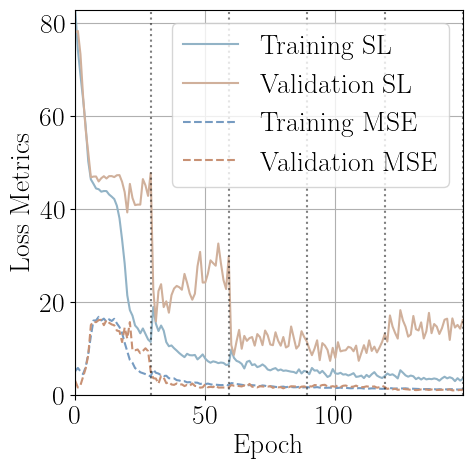

In [20]:
%matplotlib inline

fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
# ax2 = ax1.twinx()

total_loss = np.concatenate([history.history['loss'] for history in histories])
total_val_loss = np.concatenate([history.history['val_loss'] for history in histories])
total_mse = np.concatenate([history.history['mean_squared_error'] for history in histories])
total_val_mse = np.concatenate([history.history['val_mean_squared_error'] for history in histories])
nEpochs = [len(history.history['loss']) for history in histories]

maxY = max(np.max(total_loss), np.max(total_val_loss))

ax1.plot(total_loss, label='Training SL', color=twilight[5,:])
ax1.plot(total_val_loss, label='Validation SL', color=twilight[40-5,:])

ax1.plot(total_mse, label='Training MSE', color=twilight[7,:], linestyle='--')
ax1.plot(total_val_mse, label='Validation MSE', color=twilight[40-7,:] , linestyle='--')

ax1.vlines(np.cumsum(nEpochs)-1, 0, maxY, color='k', linestyle=':', alpha=0.5)

# ax2.plot(history.history['accuracy'], label='Training Accuracy', color=twilight[9,:], linestyle=':')
# ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color=twilight[40-9,:], linestyle=':')
# ax1.plot([], [], label='Training Accuracy', color=twilight[9,:], linestyle=':')
# ax1.plot([], [], label='Validation Accuracy', color=twilight[40-9,:], linestyle=':')

ax1.set_xlabel('Epoch')

ax1.set_ylabel('Loss Metrics')
# ax2.set_ylabel('Accuracy Metrics')

# ax1.set_yscale('log')
# ax2.set_yscale('log')

ax1.set_xlim(0, len(total_loss)-1)
# ax2.set_xlim(0, len(history.history['loss'])-1)
ax1.set_ylim(0, maxY)
# ax2.set_ylim(ymin=0, ymax=1)

ax1.grid()
# ax2.grid()

# ax1.set_title('Training history')
ax1.legend()
plt.show()

In [21]:
saveModel = False
loadModel = False

# fileName = 'models/model_{}_{}.h5'.format(plotRecoName, {True:'withErrors', False:'noErrors'}[makeErrors])
fileName = 'models/model_200multievent_20x20x20_5kFold_30epochs_primaryLabels.h5'
if saveModel:
    model.save(fileName)
    print('Saved model to', fileName)
if loadModel:
    model = tf.keras.models.load_model(fileName, custom_objects={'sparseLoss': sparseLoss})
    print('Loaded model from', fileName)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 121/121 [00:08<00:00, 14.39it/s]


(7,)
[  0.   0. 121.   0. 121.   0. 121.]
(6,)
[0. 0. 0. 0. 0. 0.]


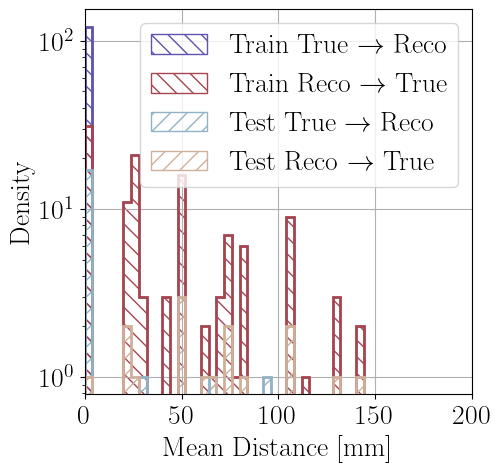

In [22]:
nBins = 50
xmax = 200
# xmax = None
lw = 2
colors = [twilight[5,:], twilight[40-5,:], twilight[12,:], twilight[40-12,:]]
density = False
plots = [True, False]

meanDistanceFromTrueToReco_test = []
meanDistanceFromRecoToTrue_test = []
meanDistanceFromTrueToReco_train = []
meanDistanceFromRecoToTrue_train = []
distancesFromTrueToReco_test = []
distancesFromRecoToTrue_test = []
distancesFromTrueToReco_train = []
distancesFromRecoToTrue_train = []

for i in tqdm.tqdm(range(len(X_test))):
    mean, distances = meanAndDistancesFromTrueToReco(Y_test[i], model.predict(X_test[i:i+1], verbose=0)[0], eps=12, optimize=True, minEntries=20, deltaEps=0.1)
    meanDistanceFromTrueToReco_test.append(mean)
    distancesFromTrueToReco_test.append(distances.numpy())

    mean, distances = meanAndDistancesFromRecoToTrue(Y_test[i], model.predict(X_test[i:i+1], verbose=0)[0], eps=12, optimize=True, minEntries=20, deltaEps=0.1)
    meanDistanceFromRecoToTrue_test.append(mean)
    distancesFromRecoToTrue_test.append(distances.numpy())
for i in tqdm.tqdm(range(len(X_train))):
    mean, distances = meanAndDistancesFromTrueToReco(Y_train[i], model.predict(X_train[i:i+1], verbose=0)[0], eps=12, optimize=True, minEntries=20, deltaEps=0.1)
    meanDistanceFromTrueToReco_train.append(mean)
    distancesFromTrueToReco_train.append(distances.numpy())

    mean, distances = meanAndDistancesFromRecoToTrue(Y_train[i], model.predict(X_train[i:i+1], verbose=0)[0], eps=12, optimize=True, minEntries=20, deltaEps=0.1)
    meanDistanceFromRecoToTrue_train.append(mean)
    distancesFromRecoToTrue_train.append(distances.numpy())

print(distancesFromRecoToTrue_test[0].shape)
print(distancesFromRecoToTrue_test[0])
print(distancesFromTrueToReco_test[0].shape)
print(distancesFromTrueToReco_test[0])

meanDistanceFromTrueToReco_test = np.array(meanDistanceFromTrueToReco_test)
meanDistanceFromRecoToTrue_test = np.array(meanDistanceFromRecoToTrue_test)
meanDistanceFromTrueToReco_train = np.array(meanDistanceFromTrueToReco_train)
meanDistanceFromRecoToTrue_train = np.array(meanDistanceFromRecoToTrue_train)

meanDistanceFromTrueToReco_test = meanDistanceFromTrueToReco_test[~np.isnan(meanDistanceFromTrueToReco_test)]
meanDistanceFromRecoToTrue_test = meanDistanceFromRecoToTrue_test[~np.isnan(meanDistanceFromRecoToTrue_test)]
meanDistanceFromTrueToReco_train = meanDistanceFromTrueToReco_train[~np.isnan(meanDistanceFromTrueToReco_train)]
meanDistanceFromRecoToTrue_train = meanDistanceFromRecoToTrue_train[~np.isnan(meanDistanceFromRecoToTrue_train)]

for i in range(len(distancesFromRecoToTrue_test)):
    distancesFromRecoToTrue_test[i] = distancesFromRecoToTrue_test[i][~np.isnan(distancesFromRecoToTrue_test[i])]
for i in range(len(distancesFromTrueToReco_test)):
    distancesFromTrueToReco_test[i] = distancesFromTrueToReco_test[i][~np.isnan(distancesFromTrueToReco_test[i])]
for i in range(len(distancesFromRecoToTrue_train)):
    distancesFromRecoToTrue_train[i] = distancesFromRecoToTrue_train[i][~np.isnan(distancesFromRecoToTrue_train[i])]
for i in range(len(distancesFromTrueToReco_train)):
    distancesFromTrueToReco_train[i] = distancesFromTrueToReco_train[i][~np.isnan(distancesFromTrueToReco_train[i])]

##################################################################################################################
##################################################################################################################
##################################################################################################################

if plots[0] and plots[1]:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
elif plots[0] or plots[1]:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax = [ax, ax]

if plots[0]:
    if xmax is None:
        xmax = np.max([np.max(meanDistanceFromRecoToTrue_test), np.max(meanDistanceFromTrueToReco_test), np.max(meanDistanceFromTrueToReco_train), np.max(meanDistanceFromTrueToReco_train)])


    bins_TR_train, edges_TR_train, _ = ax[0].hist(meanDistanceFromTrueToReco_train, bins=nBins, range=(0, xmax), histtype='step', color=colors[2], linewidth=lw, density=density)
    bins_RT_train, edges_RT_train, _ = ax[0].hist(meanDistanceFromRecoToTrue_train, bins=nBins, range=(0, xmax), histtype='step', color=colors[3], linewidth=lw, density=density)
    bins_TR_test, edges_TR_test, _ = ax[0].hist(meanDistanceFromTrueToReco_test, bins=nBins, range=(0, xmax), histtype='step', color=colors[0], linewidth=lw, density=density)
    bins_RT_test, edges_RT_test, _ = ax[0].hist(meanDistanceFromRecoToTrue_test, bins=nBins, range=(0, xmax), histtype='step', color=colors[1], linewidth=lw, density=density)

    bins_TR_train_step = np.insert(bins_TR_train.repeat(2), [0, len(bins_TR_train)*2], 0)
    bins_RT_train_step = np.insert(bins_RT_train.repeat(2), [0, len(bins_RT_train)*2], 0)
    bins_TR_test_step = np.insert(bins_TR_test.repeat(2), [0, len(bins_TR_test)*2], 0)
    bins_RT_test_step = np.insert(bins_RT_test.repeat(2), [0, len(bins_RT_test)*2], 0)

    edges_TR_train_step = np.array(edges_TR_train).repeat(2)
    edges_RT_train_step = np.array(edges_RT_train).repeat(2)
    edges_TR_test_step = np.array(edges_TR_test).repeat(2)
    edges_RT_test_step = np.array(edges_RT_test).repeat(2)

    path_TR_train = Path(np.array([edges_TR_train_step, bins_TR_train_step]).T)
    path_RT_train = Path(np.array([edges_RT_train_step, bins_RT_train_step]).T)
    path_TR_test = Path(np.array([edges_TR_test_step, bins_TR_test_step]).T)
    path_RT_test = Path(np.array([edges_RT_test_step, bins_RT_test_step]).T)

    patch_TR_train = PathPatch(path_TR_train, facecolor='None', edgecolor=colors[2], alpha=1, hatch=r'\\', label=r'Train True $\to$ Reco')
    patch_RT_train = PathPatch(path_RT_train, facecolor='None', edgecolor=colors[3], alpha=1, hatch=r'\\', label=r'Train Reco $\to$ True')
    patch_TR_test = PathPatch(path_TR_test, facecolor='None', edgecolor=colors[0], alpha=1, hatch='//', label=r'Test True $\to$ Reco')
    patch_RT_test = PathPatch(path_RT_test, facecolor='None', edgecolor=colors[1], alpha=1, hatch='//', label=r'Test Reco $\to$ True')

    ax[0].add_patch(patch_TR_train)
    ax[0].add_patch(patch_RT_train)
    ax[0].add_patch(patch_TR_test)
    ax[0].add_patch(patch_RT_test)

    ax[0].set_yscale('log')
    ax[0].set_xlabel('Mean Distance [mm]')
    ax[0].set_ylabel('Density')
    ax[0].set_xlim(0, xmax)
    ax[0].legend()
    ax[0].grid()

##################################################################################################################
##################################################################################################################
##################################################################################################################

if plots[1]:
    if xmax is None:
        xmax = np.max([np.max(np.concatenate(distancesFromRecoToTrue_train)), np.max(np.concatenate(distancesFromTrueToReco_train)), np.max(np.concatenate(distancesFromRecoToTrue_test)), np.max(np.concatenate(distancesFromTrueToReco_test))])

    bins_TR_train, edges_TR_train, _ = ax[1].hist(np.concatenate(distancesFromTrueToReco_train), bins=nBins, range=(0, xmax), histtype='step', color=colors[2], linewidth=lw, density=density)
    bins_RT_train, edges_RT_train, _ = ax[1].hist(np.concatenate(distancesFromRecoToTrue_train), bins=nBins, range=(0, xmax), histtype='step', color=colors[3], linewidth=lw, density=density)
    bins_TR_test, edges_TR_test, _ = ax[1].hist(np.concatenate(distancesFromTrueToReco_test), bins=nBins, range=(0, xmax), histtype='step', color=colors[0], linewidth=lw, density=density)
    bins_RT_test, edges_RT_test, _ = ax[1].hist(np.concatenate(distancesFromRecoToTrue_test), bins=nBins, range=(0, xmax), histtype='step', color=colors[1], linewidth=lw, density=density)

    bins_TR_train_step = np.insert(bins_TR_train.repeat(2), [0, len(bins_TR_train)*2], 0)
    bins_RT_train_step = np.insert(bins_RT_train.repeat(2), [0, len(bins_RT_train)*2], 0)
    bins_TR_test_step = np.insert(bins_TR_test.repeat(2), [0, len(bins_TR_test)*2], 0)
    bins_RT_test_step = np.insert(bins_RT_test.repeat(2), [0, len(bins_RT_test)*2], 0)

    edges_TR_train_step = np.array(edges_TR_train).repeat(2)
    edges_RT_train_step = np.array(edges_RT_train).repeat(2)
    edges_TR_test_step = np.array(edges_TR_test).repeat(2)
    edges_RT_test_step = np.array(edges_RT_test).repeat(2)

    path_TR_train = Path(np.array([edges_TR_train_step, bins_TR_train_step]).T)
    path_RT_train = Path(np.array([edges_RT_train_step, bins_RT_train_step]).T)
    path_TR_test = Path(np.array([edges_TR_test_step, bins_TR_test_step]).T)
    path_RT_test = Path(np.array([edges_RT_test_step, bins_RT_test_step]).T)

    patch_TR_train = PathPatch(path_TR_train, facecolor='None', edgecolor=colors[2], alpha=1, hatch=r'\\', label=r'Train True $\to$ Reco')
    patch_RT_train = PathPatch(path_RT_train, facecolor='None', edgecolor=colors[3], alpha=1, hatch=r'\\', label=r'Train Reco $\to$ True')
    patch_TR_test = PathPatch(path_TR_test, facecolor='None', edgecolor=colors[0], alpha=1, hatch='//', label=r'Test True $\to$ Reco')
    patch_RT_test = PathPatch(path_RT_test, facecolor='None', edgecolor=colors[1], alpha=1, hatch='//', label=r'Test Reco $\to$ True')

    ax[1].add_patch(patch_TR_train)
    ax[1].add_patch(patch_RT_train)
    ax[1].add_patch(patch_TR_test)
    ax[1].add_patch(patch_RT_test)

    ax[1].set_yscale('log')
    ax[1].set_xlabel('Distance [mm]')
    ax[1].set_ylabel('Density')
    ax[1].set_xlim(0, xmax)
    ax[1].legend()
    ax[1].grid()

plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_94593/381091056.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(grid_pos[nonZeroInd,0], grid_pos[nonZeroInd,1], grid_pos[nonZeroInd,2], c='k', cmap=cm.viridis, s=30, alpha=0.8, marker='o')


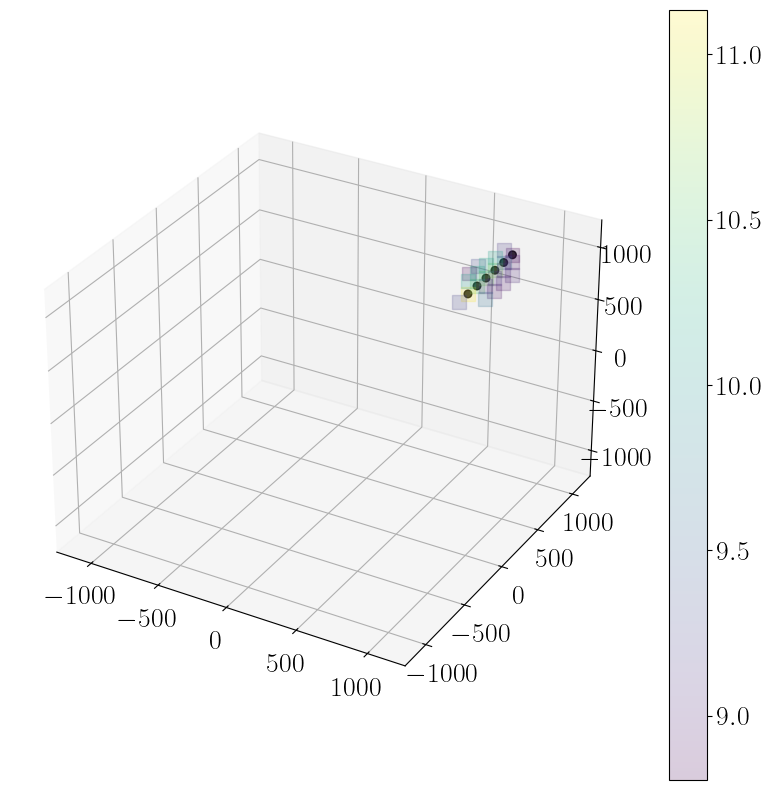

  5%|▌         | 1/20 [00:00<00:02,  6.80it/s]

1/1 [==============================] - 0s 20ms/step


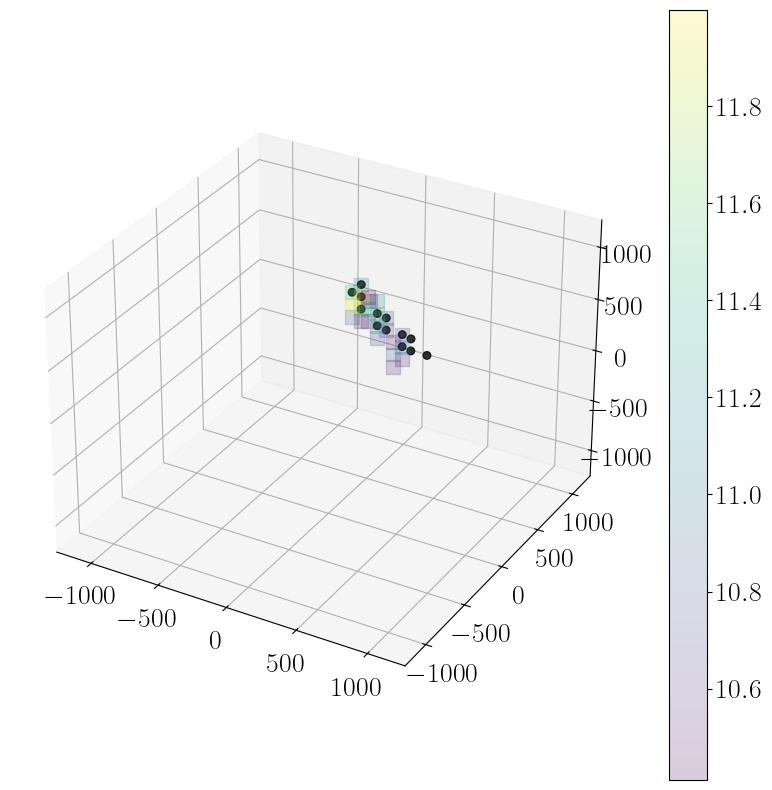

 10%|█         | 2/20 [00:00<00:02,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


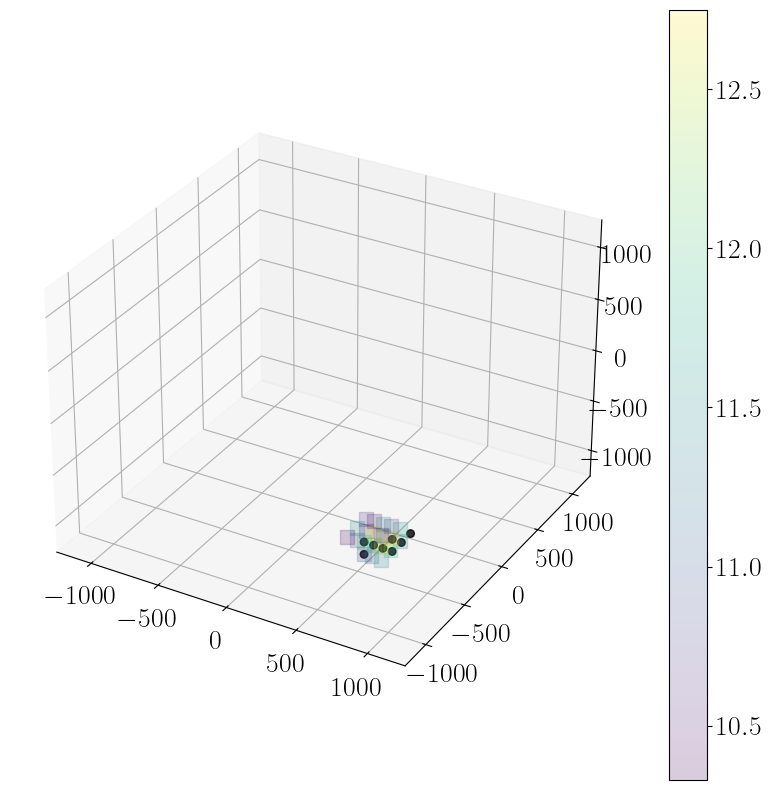

 15%|█▌        | 3/20 [00:00<00:02,  7.48it/s]

1/1 [==============================] - 0s 21ms/step


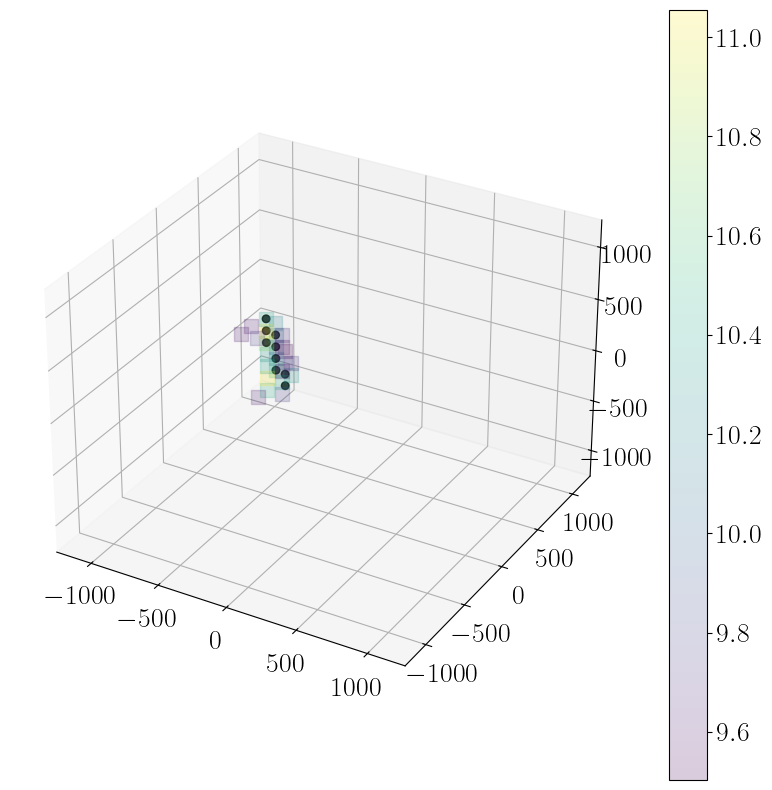

 20%|██        | 4/20 [00:00<00:02,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


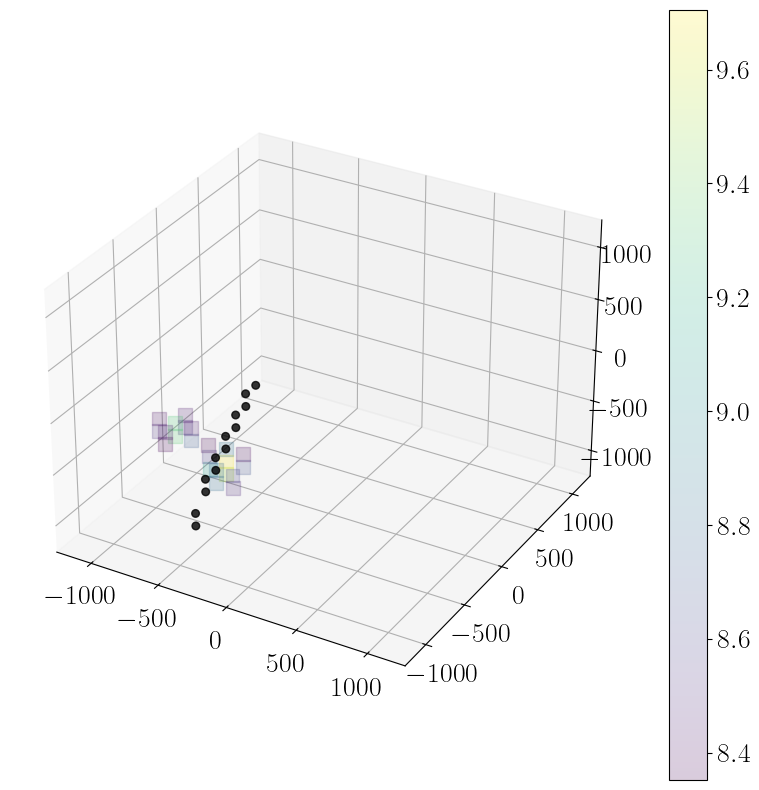

 25%|██▌       | 5/20 [00:00<00:01,  7.53it/s]

1/1 [==============================] - 0s 20ms/step


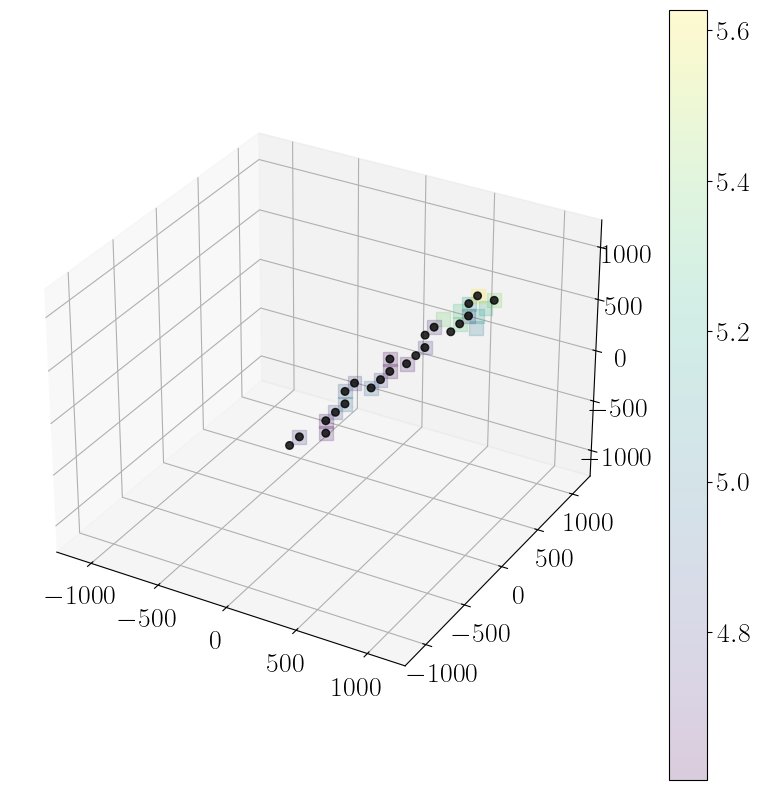

 30%|███       | 6/20 [00:00<00:01,  7.72it/s]

1/1 [==============================] - 0s 21ms/step


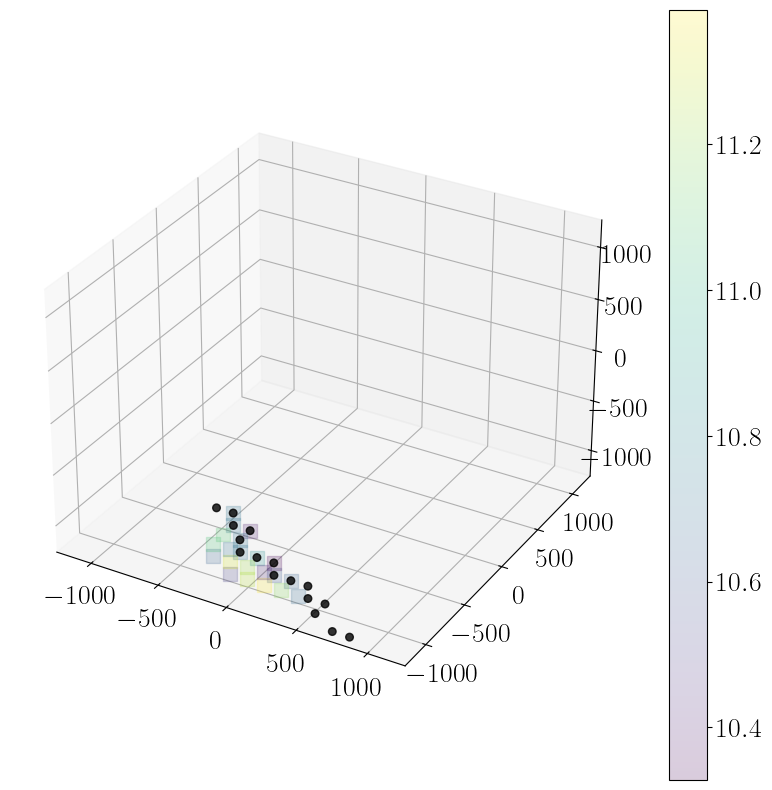

 35%|███▌      | 7/20 [00:00<00:01,  7.80it/s]

1/1 [==============================] - 0s 20ms/step


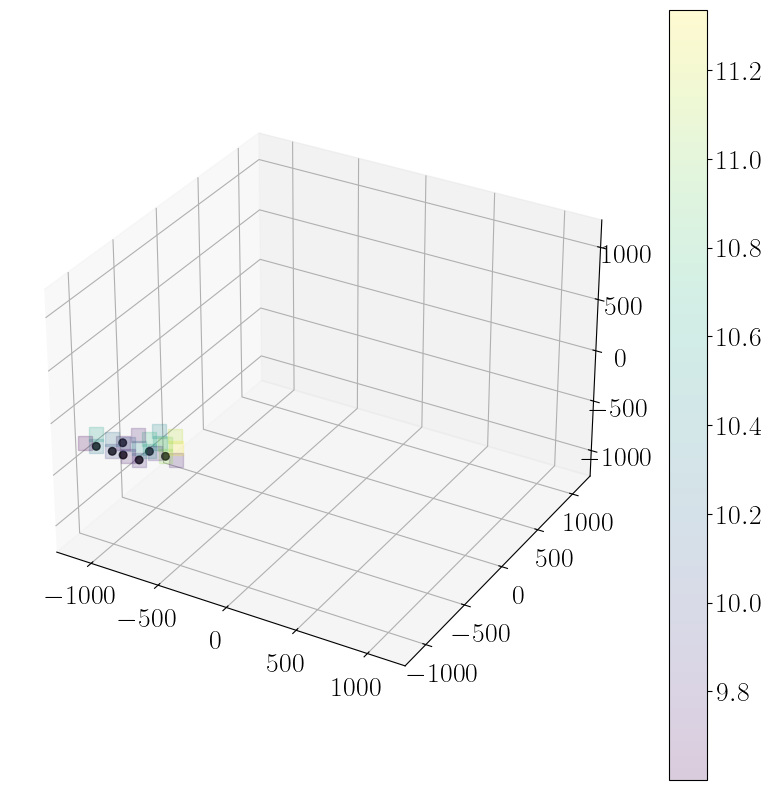

 40%|████      | 8/20 [00:01<00:01,  7.80it/s]

1/1 [==============================] - 0s 20ms/step


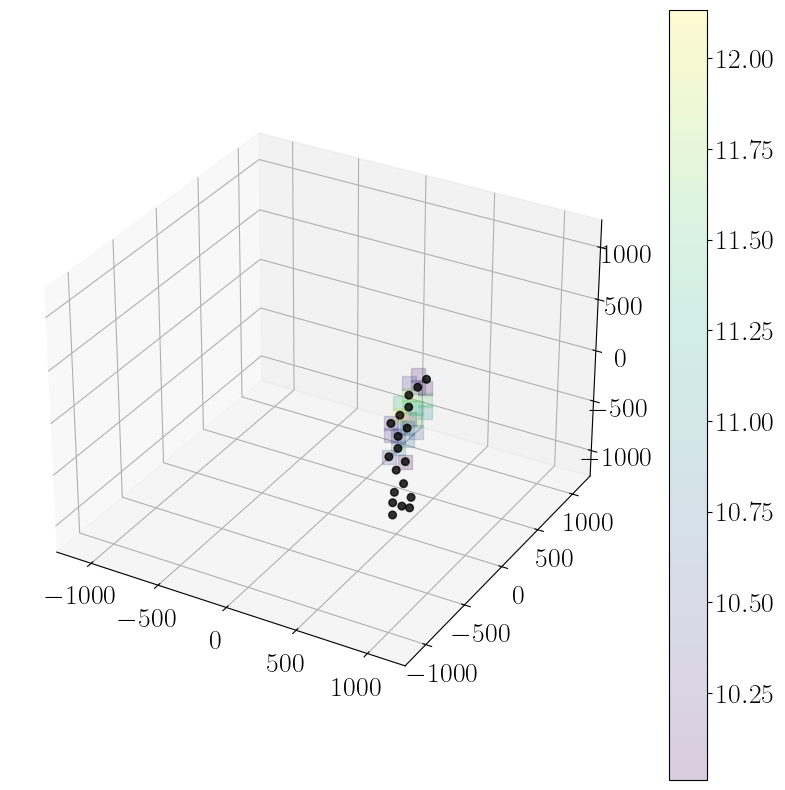

 45%|████▌     | 9/20 [00:01<00:01,  7.66it/s]

1/1 [==============================] - 0s 21ms/step


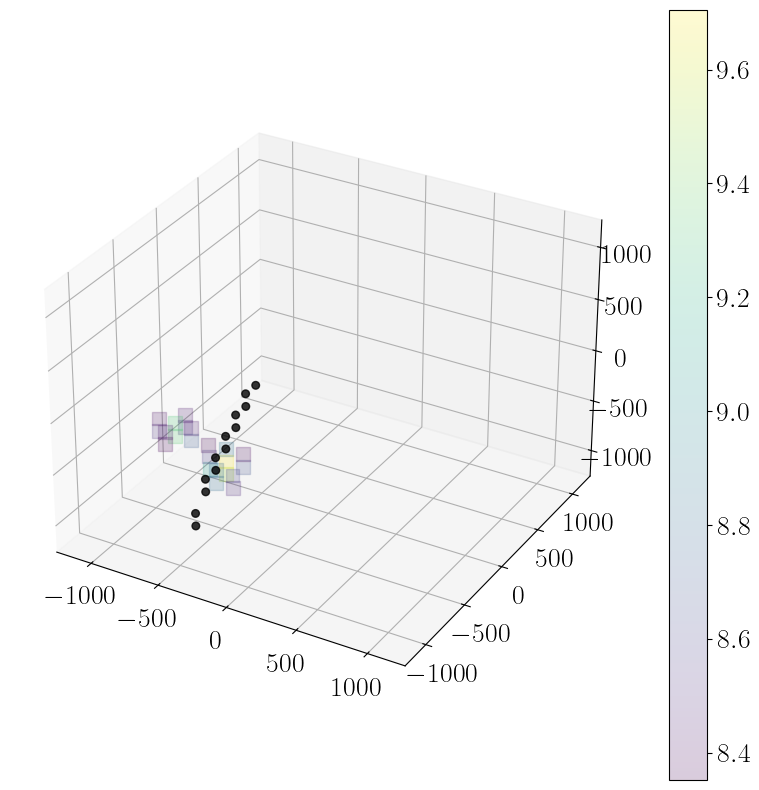

 50%|█████     | 10/20 [00:01<00:01,  7.75it/s]

1/1 [==============================] - 0s 23ms/step


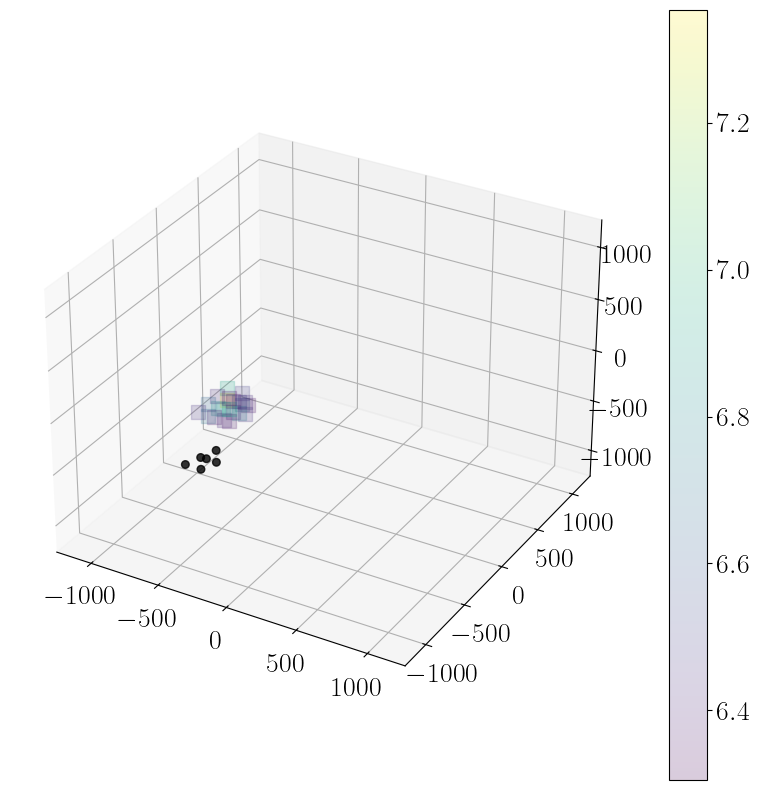

 55%|█████▌    | 11/20 [00:01<00:02,  3.38it/s]

1/1 [==============================] - 0s 47ms/step


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_94593/381091056.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(grid_pos[nonZeroInd,0], grid_pos[nonZeroInd,1], grid_pos[nonZeroInd,2], c='k', cmap=cm.viridis, s=30, alpha=0.8, marker='o')


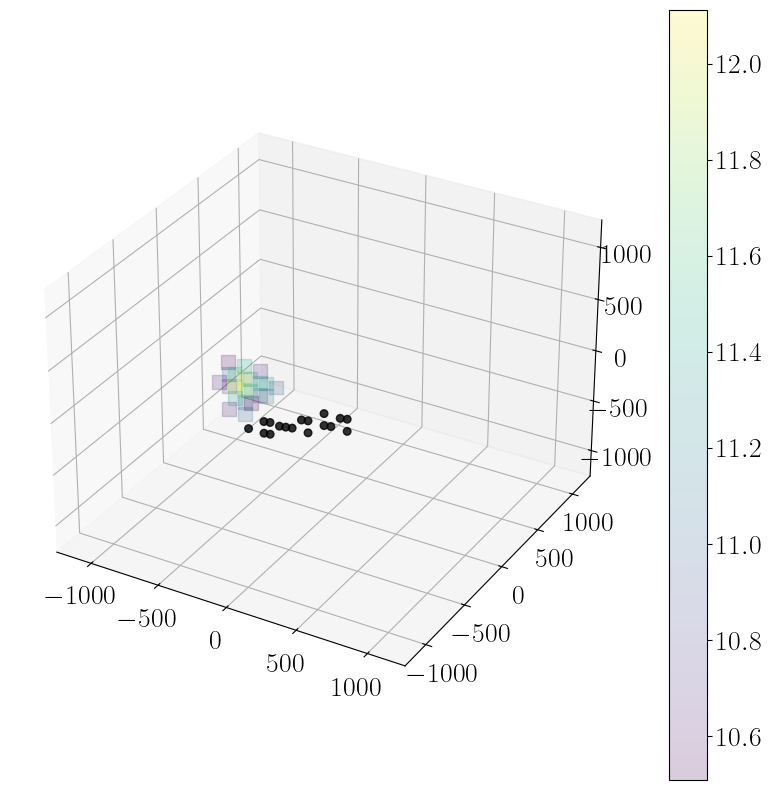

 60%|██████    | 12/20 [00:02<00:02,  3.60it/s]

1/1 [==============================] - 0s 20ms/step


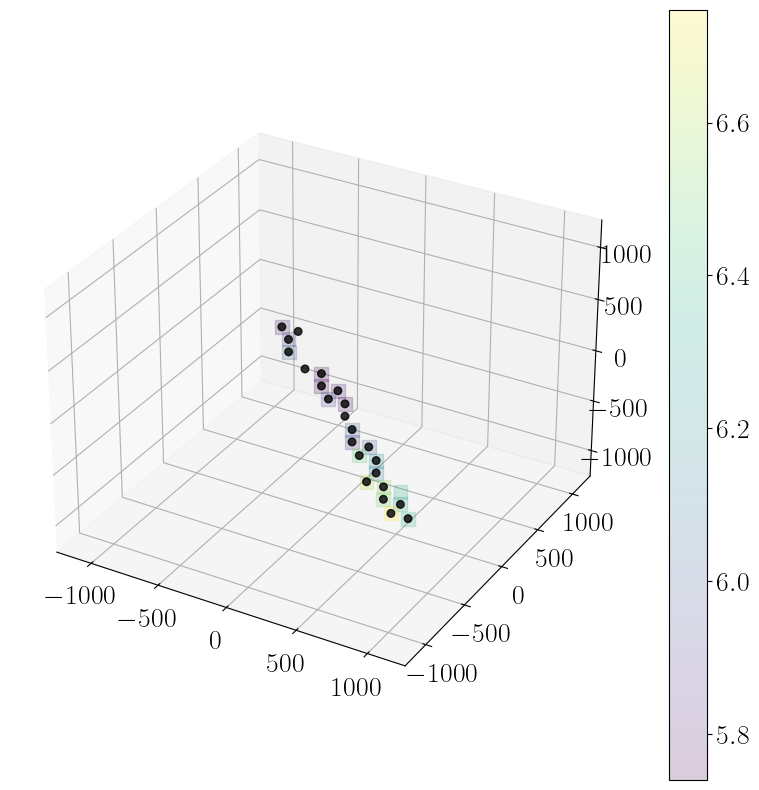

 65%|██████▌   | 13/20 [00:02<00:01,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


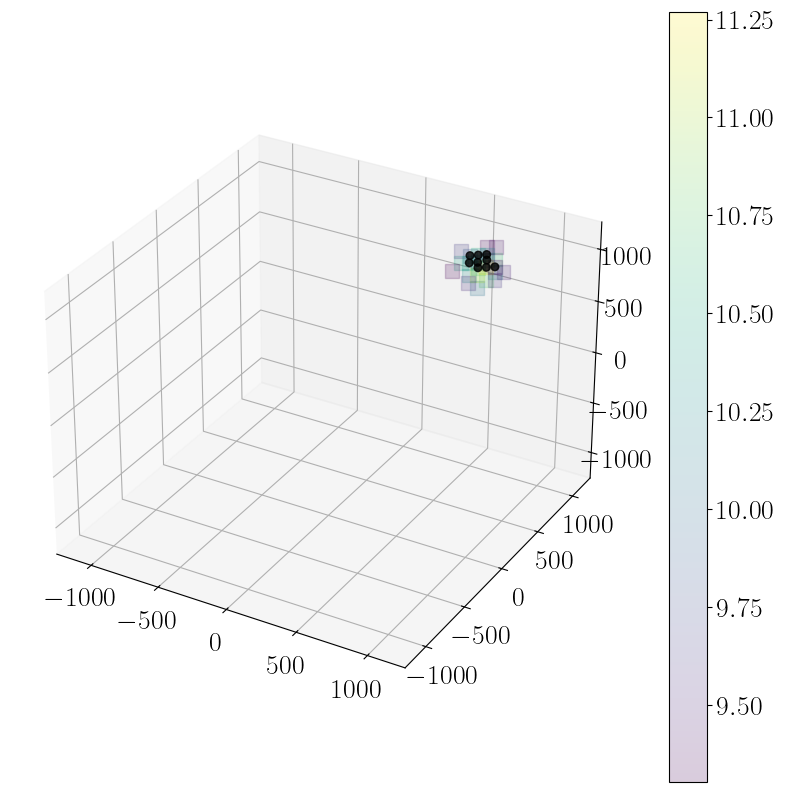

 70%|███████   | 14/20 [00:02<00:01,  4.92it/s]

1/1 [==============================] - 0s 26ms/step


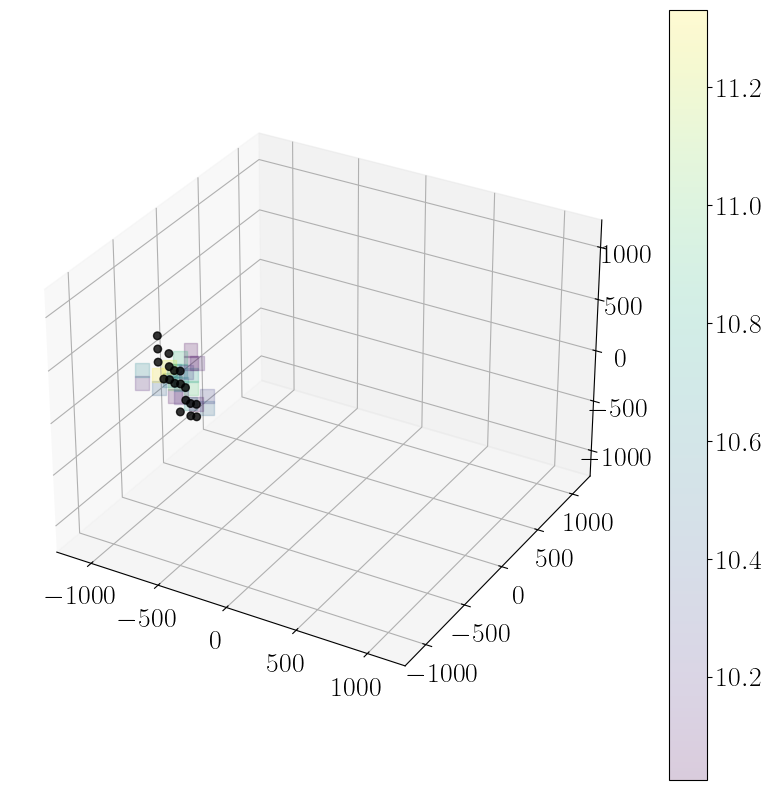

 75%|███████▌  | 15/20 [00:02<00:00,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


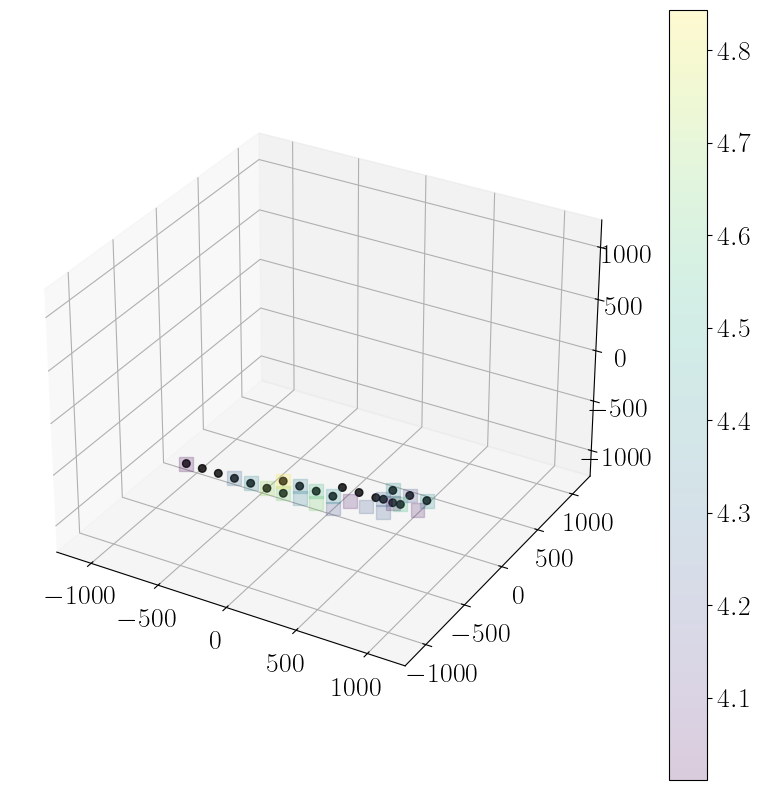

 80%|████████  | 16/20 [00:03<00:01,  2.34it/s]

1/1 [==============================] - 0s 101ms/step


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_94593/381091056.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(grid_pos[nonZeroInd,0], grid_pos[nonZeroInd,1], grid_pos[nonZeroInd,2], c='k', cmap=cm.viridis, s=30, alpha=0.8, marker='o')


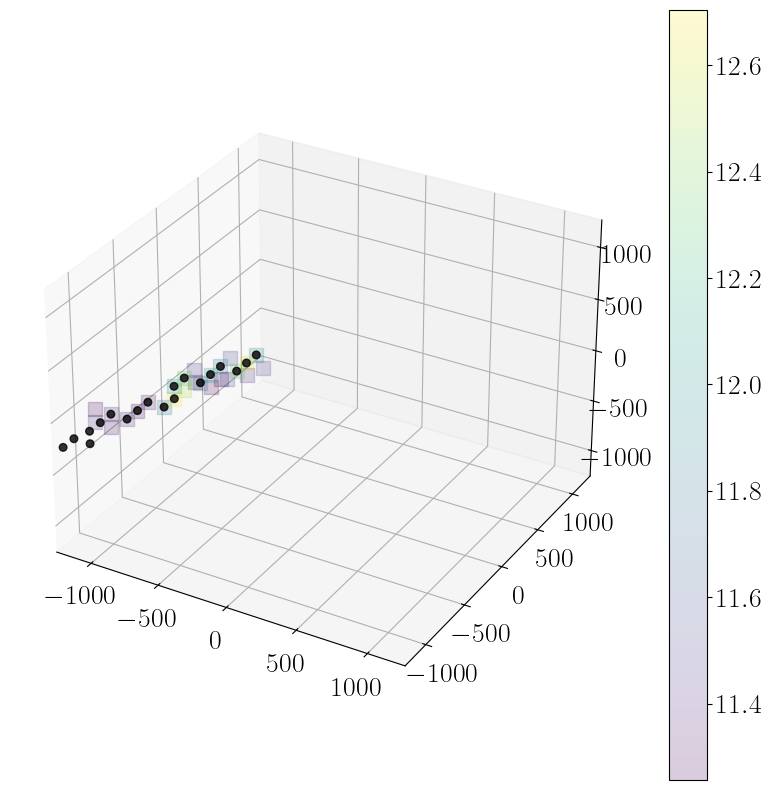

 85%|████████▌ | 17/20 [00:04<00:02,  1.49it/s]

1/1 [==============================] - 0s 36ms/step


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_94593/381091056.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(grid_pos[nonZeroInd,0], grid_pos[nonZeroInd,1], grid_pos[nonZeroInd,2], c='k', cmap=cm.viridis, s=30, alpha=0.8, marker='o')


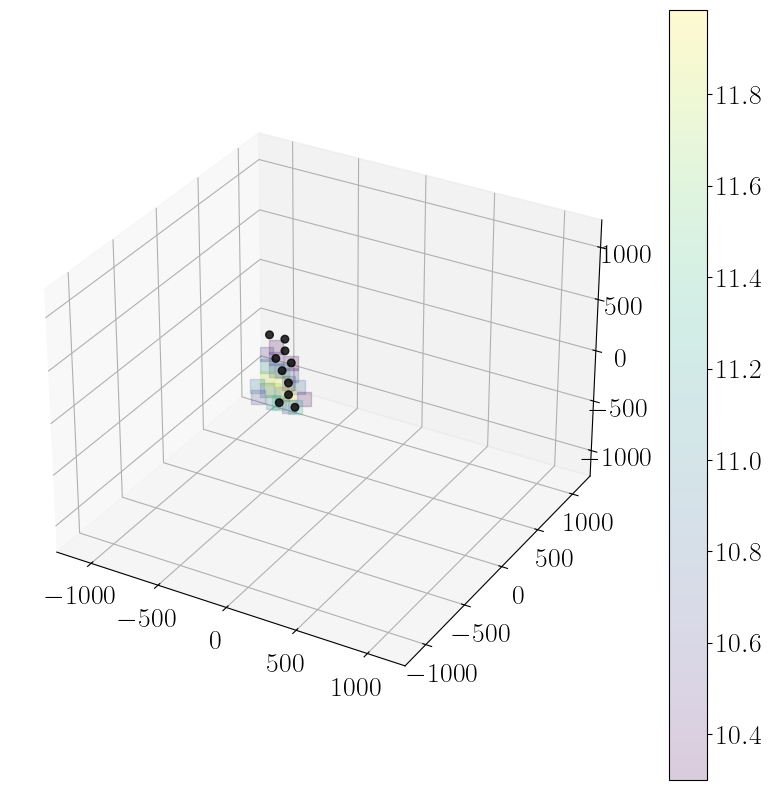

 90%|█████████ | 18/20 [00:05<00:01,  1.78it/s]

1/1 [==============================] - 0s 20ms/step


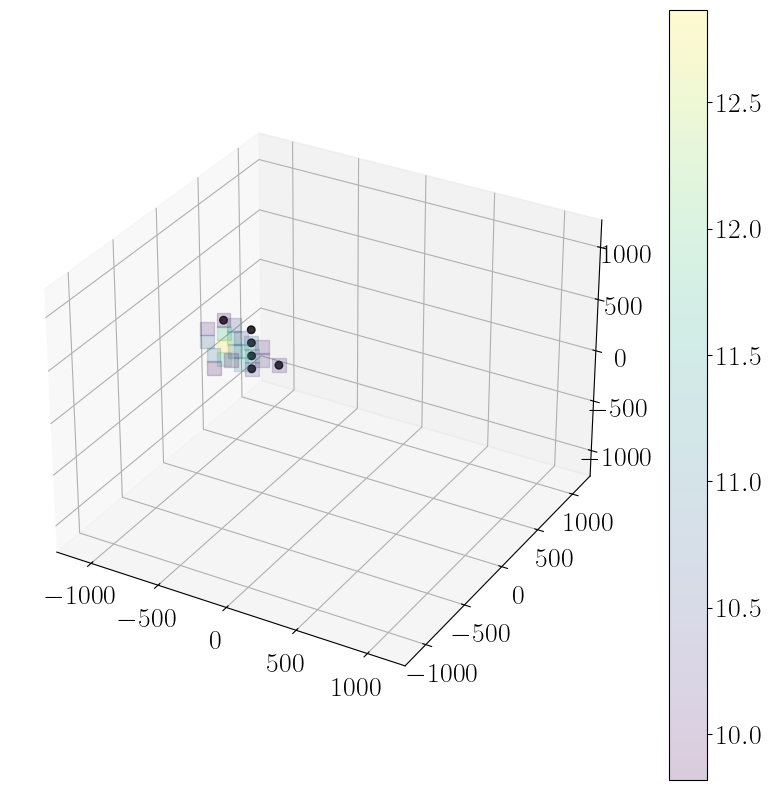

 95%|█████████▌| 19/20 [00:05<00:00,  2.34it/s]

1/1 [==============================] - 0s 19ms/step


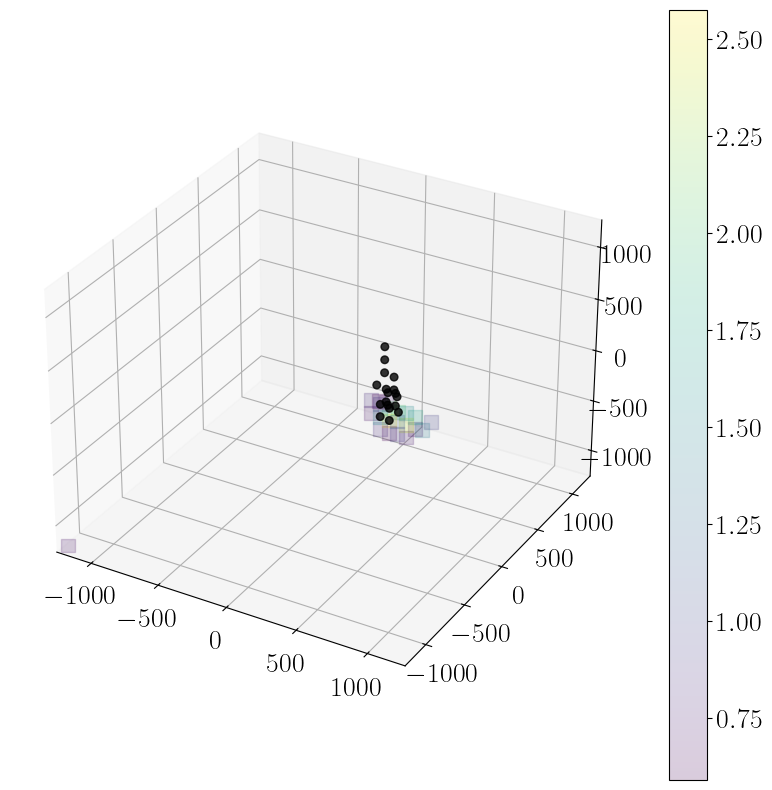

100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


In [23]:
# %matplotlib qt
%matplotlib inline

inds = range(len(X_test))
# inds = [2]
epsInit = 12 # 0.2
minNshown = 20

for ind in tqdm.tqdm(inds):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    trueGrid = Y_test[ind]
    # trueGrid = zoom(Y_test[ind], [
    #     gridSize_input[0]/gridSize_output[0], 
    #     gridSize_input[1]/gridSize_output[1], 
    #     gridSize_input[2]/gridSize_output[2]])
    predGrid = model.predict(X_test[ind].reshape(1, 
                                            gridSize_input[0], 
                                            gridSize_input[1], 
                                            gridSize_input[2], 
                                            6)).reshape(gridSize_output)
    # predGrid = zoom(predGrid, [
    #     gridSize_input[0]/gridSize_output[0], 
    #     gridSize_input[1]/gridSize_output[1], 
    #     gridSize_input[2]/gridSize_output[2]])
    truePos  = np.array(dfs_hits[ind]['initialPosition'].to_list())

    eps = epsInit
    while True:
        nonZeroInd = np.where(predGrid.flatten()>eps)
        if len(nonZeroInd[0]) > minNshown:
            break
        elif eps < 0:
            break
        eps -= 0.1
    scatter = ax.scatter(grid_pos[nonZeroInd,0], grid_pos[nonZeroInd,1], grid_pos[nonZeroInd,2], c=predGrid.flatten()[nonZeroInd], cmap=cm.viridis, s=100, alpha=0.2, marker='s')
    plt.colorbar(scatter)
    
    nonZeroInd = np.where(trueGrid.flatten()>0)
    ax.scatter(grid_pos[nonZeroInd,0], grid_pos[nonZeroInd,1], grid_pos[nonZeroInd,2], c='k', cmap=cm.viridis, s=30, alpha=0.8, marker='o')

    # ax.scatter(truePos[:,0], truePos[:,1], truePos[:,2], c='g', cmap=cm.viridis, s=100, alpha=1)

    ax.set_xlim(-DETECTOR_SIZE_MM[0]/2, DETECTOR_SIZE_MM[0]/2)
    ax.set_ylim(-DETECTOR_SIZE_MM[1]/2, DETECTOR_SIZE_MM[1]/2)
    ax.set_zlim(-DETECTOR_SIZE_MM[2]/2, DETECTOR_SIZE_MM[2]/2)

    plt.show()